# Финальный проект специализации "Машинное обучение и анализ данных"
## Идентификация интернет-пользователей
*Алексей Галак*

### Цели и задачи проекта

В рамках проекта решается задача идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

Мы будем решать похожую задачу. Есть некоторый определенный, выделенный пользователь (назовем его Alice). По последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком (сессии), мы будем определять, Alice это или кто-то другой (взломщик).

Для этой задачи есть [соревнование](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на Kaggle, на которое мы и будем опираться при итоговой оценке качества модели и для сравнения результатов с другими участниками соревнования.

Мы будем строить вероятностную модель бинарной классификации, которая для каждой сессии будет вычислять вероятность того, что эта сессия принадлежит Alice. Соответственно, чем ближе эта вероятность к 1, тем больше уверенность модели в том, что эта сессия принадлежит Alice, а чем она ближе к 0, тем больше уверенность в том, что сессия принадлежит не Alice.

### Описание данных

Обучающая выборка приведена в файле `train_sessions.csv`,  тестовая (без целевого признака) - в файле `test_sessions.csv`.

Данные представлены в виде сессий - последовательностей сайтов, посещенных одним человеком. Каждый посещенный сайт представлен идентификатором и временем посещения. Длина сессии ограничена 10 сайтами, но может быть и меньше (в этом случае соответствующие сайту признаки отсутствуют). Сопоставление сайтов (доменных имен) и их идентификаторов приведено в pickle-файле со словарем `site_dic.pkl`.
* Признаки `site_i`, i=1..10 – идентификаторы посещенных сайтов
* Признаки `time_i`, i=1..10 – время посещения сайтов `site_i`
* Целевой признак `target` – индикатор того, что сессия принадлежит Alice (1 - Alice, 0 - кто-то другой)

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import re
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix, csc_matrix, hstack as shstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from boruta import BorutaPy
import eli5
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def csr_hstack(arglist):
    return csr_matrix(shstack(arglist))

In [3]:
PATH_TO_DATA = '../data/raw'
PATH_TO_SUBMISSIONS = '../kaggle_submissions'
SEED = 17

In [4]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


Тестовая выборка отделена по времени от обучающей, но внутри они перемешаны (это видно выше):

In [7]:
print('Last train time:', np.max(train_df['time1']))
print('First test time:', np.min(test_df['time1']))

Last train time: 2014-04-30 23:39:53
First test time: 2014-05-01 17:14:03


Отсортируем обучающую выборку, чтобы в дальнейшем правильно разделять выборку на фолды в кросс-валидации. Тестовую выборку сортировать не будем, т.к. ее порядок нужно сохранить для сабмишна на kaggle:

In [8]:
train_df = train_df.sort_values(by='time1')

Загрузим словарь с сопоставлениями сайт - идентификатор:

In [9]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as fin:
    site_dic = pickle.load(fin)
site_dic.items()[:5]

[(u'i1-js-14-3-01-11544-644949368-i.init.cedexis-radar.net', 13852),
 (u'static.vol24.fr', 6240),
 (u'mars.nasa.gov', 39840),
 (u'scholar.google.fr', 3899),
 (u'9zouxfza1h.s.ad6media.fr', 9677)]

### Методика измерения качества

Модель оценивается на основании предлагаемой в соревновании метрики ROC-AUC - площади под ROC-кривой. Чем выше показатель ROC-AUC, тем качественнее классификатор, при этом значение 0.5 демонстрирует непригодность выбранного метода классификации (соответствует случайному угадыванию либо константному предсказанию).

### Предобработка данных и создание признаков

На основе исходных данных создадим признаки - количества вхождений сайта в сессию, по одному для каждого сайта. Получается большая разреженная матрица.

Кроме того, создадим новые признаки:
* `start_hour` - час начала сессии (0-23)
* `time_of_day` - время суток. 0 - ночь (0:00-5:00), 1 - утро (6:00-11:00), 2 - день (12:00-17:00), 3 - вечер (18:00-23:00)
* `day_of_week` - день недели, от 0 (понедельник) до 6 (воскресенье)
* `weekend` - индикатор выходных

Все эти признаки - категориальные, поэтому перед обучением модели закодируем их с помощью one-hot encoding.

In [10]:
train_test_df = pd.concat([train_df, test_df], sort=False)
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_df_times = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(np.datetime64('NaT')).astype(np.datetime64)
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947
242171,952,947,953,946,947,946,953,955,946,947
57157,953,947,946,953,955,947,953,946,953,1033
240201,946,947,954,953,946,954,946,956,957,956
210686,946,956,946,946,955,954,946,946,946,948


In [11]:
def encode_sites_with_time_diffs(X_sites, X_timestamps):
    data = []
    row_ind = []
    col_ind = []
    max_site_ID = 0
    
    X_times = np.diff(X_timestamps.values, n=1, axis=1) / np.timedelta64(1, 's')
    #we will iterate over X_times rows but use the same indices for X_sites rows
    for row_idx, time_row in enumerate(X_times):
        
        #impute the last time
        time_row_ne = list(time_row[~np.isnan(time_row)])
        if len(time_row_ne) < 9:
            time_row_ne.append(30*60 - np.sum(time_row))
        else:
            time_row_ne.append(np.mean(time_row))
        
        #add a site time into a sparse matrix
        for site_ID, site_time in zip(list(X_sites.values[row_idx, :len(time_row_ne)]), time_row_ne):
            if site_ID > max_site_ID:
                max_site_ID = site_ID
            row_ind.append(row_idx)
            col_ind.append(site_ID) #site IDs can also serve as column indices, because they range from 0 to something
            data.append(site_time / (30*60))
    X_sparse = csr_matrix((data, (row_ind, col_ind)), shape=(X_sites.shape[0], max_site_ID+1), dtype=np.int64)
    return X_sparse[:, 1:] #exclude site ID 0

In [93]:
def sparsify_data(X, vectorizer_params, train_part=None, method='count'):
    id2site = {v:k for (k, v) in site_dic.items()}
    id2site[0] = 'unknown'
    
    X_text = [' '.join(map(id2site.get, row)) if len(row) > 0 else '' for row in X]
    #X_text = [' '.join(map(str, row)) for row in X]

    if method == 'count':
        vectorizer = CountVectorizer(**vectorizer_params)
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer(**vectorizer_params)
    else:
        raise ValueError(method)
    
    if train_part is None:
        vectorizer.fit(X_text)
    else:
        vectorizer.fit(X_text[:train_part])
    
    return vectorizer.transform(X_text)
        

def make_site_names(X_sites, site_dic, sparse=True, method='count', ngram_range=(1, 1)):
    IP_regex = r'^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$'
    site_ids_to_names = {}
    for site, site_id in site_dic.items():
        site_ids_to_names[site_id] = site if re.match(IP_regex, site) else site.split('.')[-2]
    site_ids_to_names[0] = '.' if sparse else '' #fill value for missing sites
    X_site_names = np.array([[site_ids_to_names[el] for el in row] for row in X_sites.values])
    if sparse:
        vectorizer_params = {'ngram_range': ngram_range, 'token_pattern': r'[^ ]+', 'stop_words': ['.']}
        return sparsify_data(X_site_names, vectorizer_params=vectorizer_params, method=method)
    else:
        return X_site_names

def prepare_features(X_features, feature_types):
    def extract_features(feat_type):
        empty_array = np.array([]).reshape(X_features.shape[0], 0)
        if len(feature_types[feat_type]) > 0:
            return X_features[feature_types[feat_type]].values
        else:
            return empty_array
    
    def transform_features(transformer, feat_array):
        if feat_array.shape[1] > 0:
            return transformer.fit_transform(feat_array)
        else:
            return feat_array
    
    prepared_features = extract_features('prepared')
    encoded_features = transform_features(OneHotEncoder(sparse=True, dtype=np.int16), extract_features('categorical'))
    log_features = np.log(extract_features('to_log') + 1)
    #also standard scale log features
    scaled_standard_features = transform_features(StandardScaler(), np.hstack([extract_features('to_scale_standard'), 
                                                                               log_features]))
    scaled_maxabs_features = transform_features(MaxAbsScaler(), extract_features('to_scale_maxabs'))
    
    return csr_hstack([prepared_features, 
                       encoded_features, 
                       scaled_standard_features, 
                       scaled_maxabs_features])

def count_unique_sites(row):
    row_unique = np.unique(row)
    return len(row_unique[row_unique != 0]) #0 is not a valid site ID

def count_popular_sites(sites_df, popular_sites_indicators):
    result = []
    for sites_row, popular_sites_mask in zip(sites_df.values, popular_sites_indicators):
        popular_sites = sites_row[popular_sites_mask]
        result.append( len(popular_sites) )
    return result

def get_session_timespan(row):
    row_ne = row[~np.isnat(row)]
    return int((row_ne[-1]-row_ne[0]) / np.timedelta64(1, 's'))

def between(left, x, right):
    return left <= x and x <= right

def get_time_of_day(hour):
    if between(0, hour, 6):
        return 0
    elif between(7, hour, 11):
        return 1
    elif between(12, hour, 18):
        return 2
    elif between(19, hour, 23):
        return 3

def make_features(X_sites, X_times, prepare=True):
    X_features = pd.DataFrame(index=X_sites.index)
    
    sites_counter = Counter()
    for row in X_sites.values:
        sites_counter.update(row)
    popular_sites = [site for site, count in sites_counter.most_common(30)]
    popular_sites_indicators = np.isin(X_sites.values, popular_sites)
    
    X_features['start_hour'] = X_times['time1'].dt.hour
    X_features['time_of_day'] = X_features['start_hour'].apply(get_time_of_day)
    X_features['day_of_week'] = X_times['time1'].dt.dayofweek
    X_features['weekend'] = (np.isin(X_features['day_of_week'].values, [5, 6])).astype(int)
    #X_features['#unique_sites'] = X_sites.apply(count_unique_sites, raw=True, axis=1)
    X_features['#popular_sites'] = count_popular_sites(X_sites, popular_sites_indicators)
    #X_features['%popular_sites'] = X_features['#popular_sites'] / X_features['#unique_sites']
    X_features['year_month'] = X_times['time1'].dt.strftime('%y%m').astype(int)
    X_features['session_timespan'] = X_times.apply(lambda row: get_session_timespan(row), axis=1, raw=True)
    
    feature_types = {'prepared': [],
                     'categorical': ['time_of_day', 
                                    ], 
                     'to_log': [], 
                     'to_scale_standard': ['session_timespan'], 
                     'to_scale_maxabs': ['day_of_week', 'year_month']
                    }
    
    if prepare:
        return prepare_features(X_features, feature_types)
    else:
        return X_features

In [94]:
%%time
train_part=len(train_df)
#vectorizer_params = {'ngram_range': (1, 1), 'token_pattern': r'[0-9]+', 'stop_words': ['0']}
vectorizer_params = {'ngram_range': (1, 5), 'max_features': 50000, 'tokenizer': lambda s: s.split(), 'stop_words': ['unknown']}
train_test_sparse_with_features = csr_hstack([#sparsify_data(train_test_df_sites.values, vectorizer_params, train_part), 
                                              sparsify_data(train_test_df_sites.values, vectorizer_params, train_part, method='tfidf'),  
                                              #encode_sites_with_time_diffs(train_test_df_sites, train_test_df_times), 
                                              #make_site_names(train_test_df_sites, site_dic, method='tfidf'), 
                                              make_features(train_test_df_sites, train_test_df_times) 
                                             ])
X_train_sparse = train_test_sparse_with_features[:train_part]
X_test_sparse = train_test_sparse_with_features[train_part:]
y = train_df['target'].astype('int').values

Wall time: 55.3 s


### Первичный анализ признаков

In [47]:
train_features = make_features(train_test_df_sites, train_test_df_times, prepare=False)[:len(train_df)]

In [48]:
def plot_feature_hist(feature, data, y, bins=None, apply_func=lambda x: x, figsize=(16, 5)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    ax = axes[0]
    data[y == 1][feature].apply(apply_func).hist(bins=bins, ax=ax, color='green')
    ax.set_title('Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')
    
    ax = axes[1]
    data[y == 0][feature].apply(apply_func).hist(bins=bins, ax=ax)
    ax.set_title('Not Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')

def plot_feature_count(feature, data, y, ticks=None, figsize=(16, 5)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    ax = axes[0]
    if ticks:
        sns.countplot(feature, data=data[y == 1], order=ticks.keys(), ax=ax)
        ax.set_xticklabels(ticks.values())
    else:
        sns.countplot(feature, data=data[y == 1], ax=ax)
    ax.set_title('Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')
    
    ax = axes[1]
    if ticks:
        sns.countplot(feature, data=data[y == 0], order=ticks.keys(), ax=ax)
        ax.set_xticklabels(ticks.values())
    else:
        sns.countplot(feature, data=data[y == 0], ax=ax)
    ax.set_title('Not Alice')
    ax.set_xlabel(feature)
    ax.set_ylabel(u'Количество сессий')

Распределение часа начала сессии:

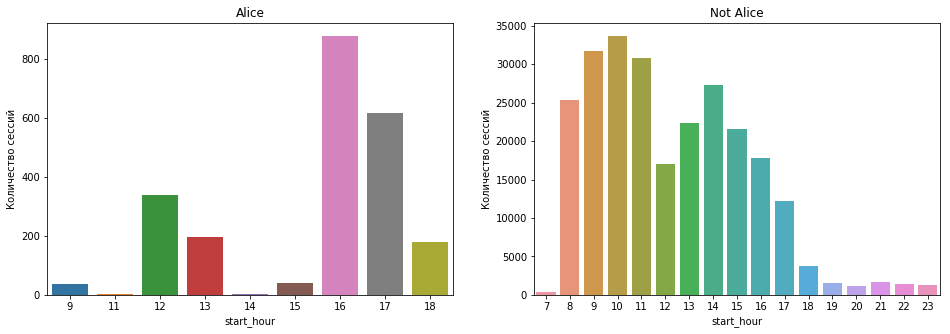

In [49]:
#plot_feature_hist('start_hour', train_features, y, bins=np.linspace(0-0.5, 23+0.5, 24+1))
plot_feature_count('start_hour', train_features, y)

*Распределения существенно отличаются. Активность Alice сконцентрирована в трех временных промежутках: 9 часов, 12-13 часов и 15-18 часов, при этом активность растет в течение дня. Активность не Alice понижается в течение дня, начинается раньше (в 8 часов) и заканчивается позже (в 23 часа), имеет лишь один спад в районе 12 часов и сильно понижается после 17 часов.*

Распределение времени суток:

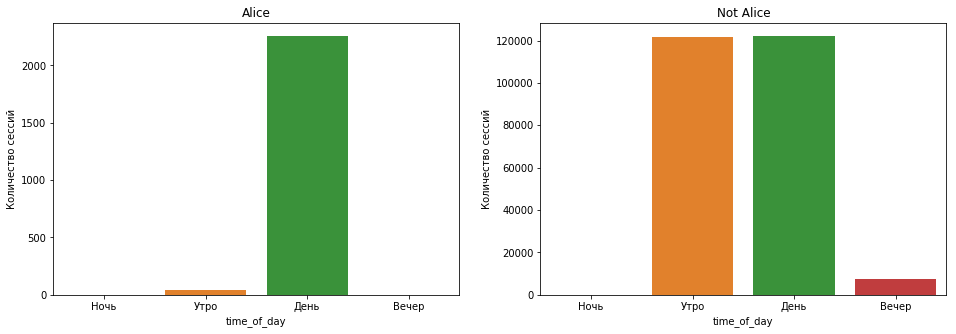

In [50]:
ticks = {0: u'Ночь', 1: u'Утро', 2: u'День', 3: u'Вечер'}
plot_feature_count('time_of_day', train_features, y, ticks=ticks)

*Как и было отмечено ранее, Alice активна в основном днем (12:00-17:00), в то время, как не Alice имеет активность утром, сопоставимую с активностью днем.*

Распределение дня недели:

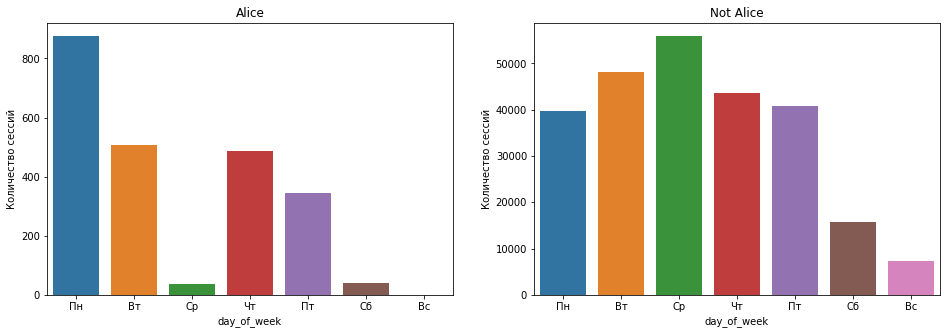

In [51]:
ticks = {0: u'Пн', 1: u'Вт', 2: u'Ср', 3: u'Чт', 4: u'Пт', 5: u'Сб', 6: u'Вс'}
plot_feature_count('day_of_week', train_features, y, ticks=ticks)

*Активность Alice максимальна в понедельник, и при этом очень мала в среду и в выходные. Активность не Alice относительно равномерна в будни и на выходные имеет лишь некоторый спад.*

Распределение индикатора выходных:

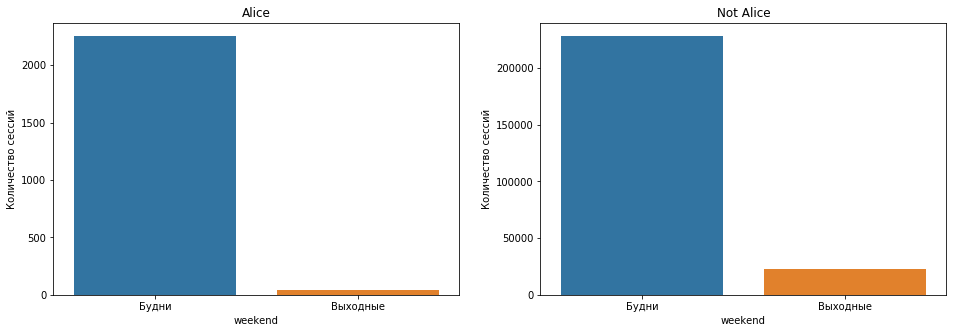

In [52]:
ticks = {0: u'Будни', 1: u'Выходные'}
plot_feature_count('weekend', train_features, y, ticks=ticks)

*Как и было отмечено ранее, Alice практически неактивна в выходные, в то время как не Alice в выходные имеет малую, но все же заметную активность.*

Распределение года+месяца:

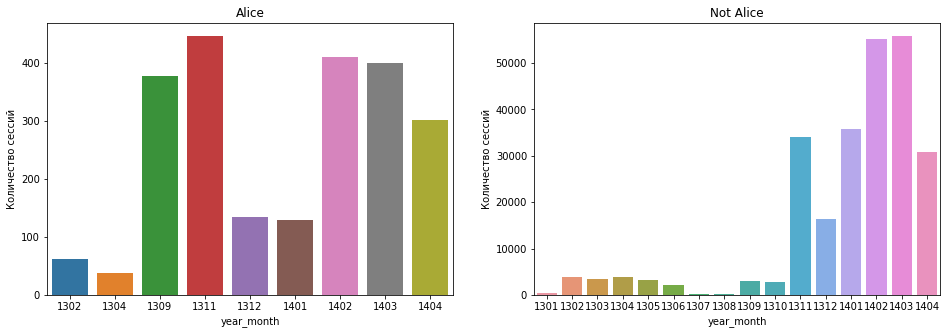

In [53]:
plot_feature_count('year_month', train_features, y)

*C мая по август, а также в октябре 2013 года Alice была неактивна. В остальные месяцы тоже есть отличия в распределениях Alice и не Alice.*

### Обучение модели

Отделим 30% обучающей выборки для валидации модели:

In [95]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Зададим тип кросс-валидации. Так как наши данные параметризованы по времени, лучше использовать `TimeSeriesSplit`:

In [96]:
tss = TimeSeriesSplit(n_splits=10)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Вспомогательная функция для отрисовки кривых валидации:

In [97]:
def plot_validation_curves(params, grid_cv_results_, scale='linear', figsize=(15, 10)):
    param_name, param_values = params.items()[0]
    plt.figure(figsize=figsize)
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    print('CV std: {}'.format(max(zip(valid_mu, valid_std), key=lambda x: x[0])[1]))
    if scale == 'linear':
        train_line = plt.plot(param_values, train_mu, '-', label='Training score', color='g')
        valid_line = plt.plot(param_values, valid_mu, '-', label='Cross-validation score', color='r')
    if scale == 'log':
        train_line = plt.semilogx(param_values, train_mu, '-', label='Training score', color='g')
        valid_line = plt.semilogx(param_values, valid_mu, '-', label='Cross-validation score', color='r')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.legend()

Обучать будем модель логистической регресии. Так как данных довольно много, будем использовать стохастический градиентный спуск (`SDGClassifier`).

Параметр `alpha` будем подбирать с помощью `GridSearchCV`. Сначала будем перебирать его на промежутке от 1e-6 до 1e3:

In [24]:
#names tfidf + year_month:
#0.9833006450214514 0.00452869433904 0.9834198937272612

Best alpha = 1e-06
Best CV score (roc auc) = 0.953454125955347
CV std: 0.00372266902748
Test score (roc auc) = 0.8877763691034735
Wall time: 38.5 s


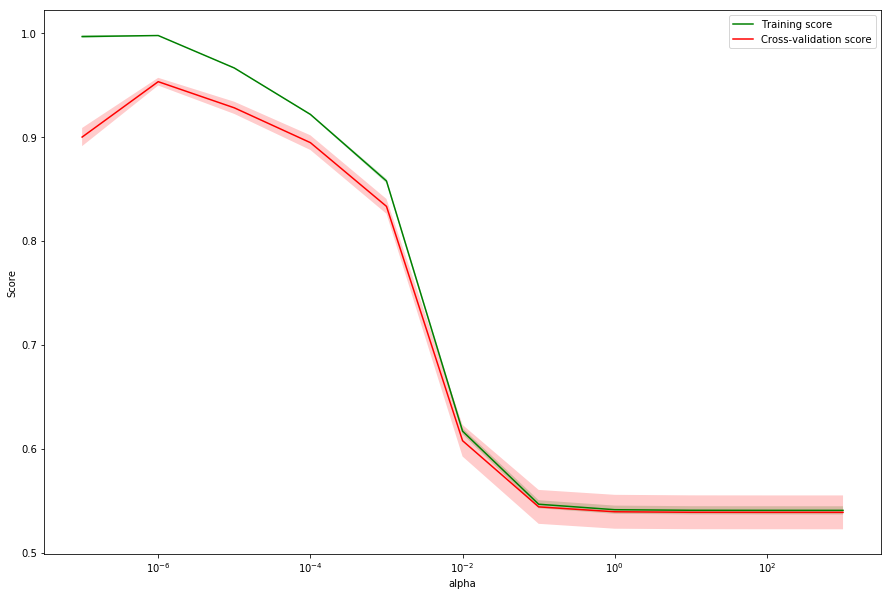

In [20]:
%%time
sgd_logit_params = {'alpha': np.logspace(-7, 3, 11)}

sgd_logit = SGDClassifier(loss='log', random_state=SEED)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best alpha =', sgd_logit_best_alpha)
print('Best CV score (roc auc) =', sgd_logit_best_score)

plot_validation_curves(sgd_logit_params, sgd_logit_grid_searcher.cv_results_, scale='log', figsize=(15, 10))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

Теперь, когда видно, где параметр `alpha` достигает максимума, переберем его вновь в более подходящем промежутке:

In [26]:
#names tfidf + year_month:
#0.9850006887961483 0.00370537212304 0.9841659700399249

Best alpha = 1.6102620275609392e-06
Best CV score (roc auc) = 0.9556254619935055
CV std: 0.00382193884428
Test score (roc auc) = 0.8865245465672116
Wall time: 52.2 s


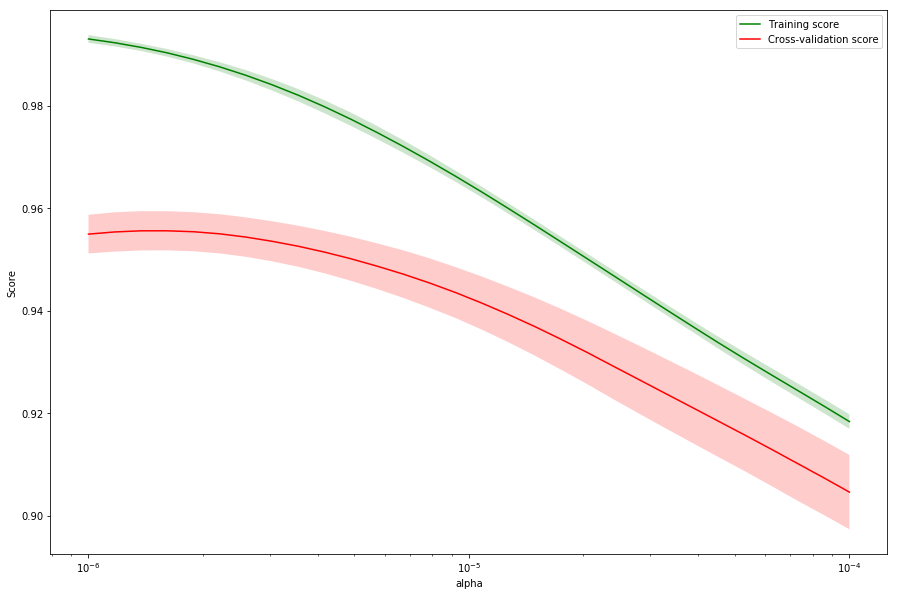

In [27]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, -4, 30)}

sgd_logit = SGDClassifier(loss='log', random_state=SEED)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best alpha =', sgd_logit_best_alpha)
print('Best CV score (roc auc) =', sgd_logit_best_score)

plot_validation_curves(sgd_logit_params, sgd_logit_grid_searcher.cv_results_, scale='log', figsize=(15, 10))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

Улучшилось и качество на кросс-валидации, и стандартное отклонение, и качество на тесте. Новое `alpha` однозначно лучше.

Построим кривые обучения:

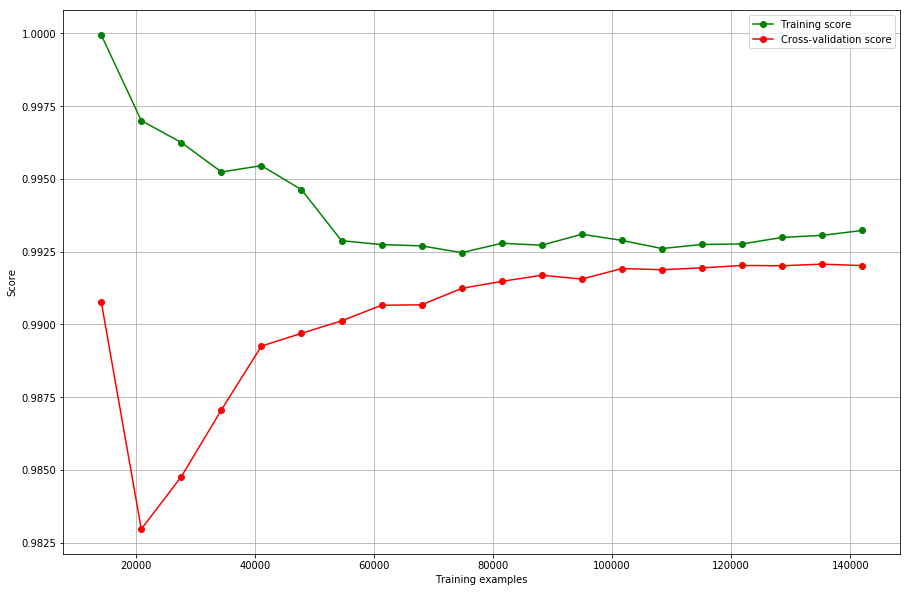

Wall time: 17.4 s


In [28]:
%%time
train_sizes_abs, train_scores, test_scores = learning_curve(sgd_logit_grid_searcher.best_estimator_, X_train, y_train, 
                                                            train_sizes=np.linspace(0.1, 1.0, 20), cv=skf)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(15, 10))
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='g', label='Training score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color='r', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

Качество на обучении и кросс-валидации приближаются друг к другу, но скорость сближения замедляется с ростом размера обучающей выборки, остается разрыв. Нет ни выраженного недообучения, ни выраженного переобучения. Стоит усложнить модель - построить новые признаки, чтобы выявить возможные закономерности, которые отличают тестовые данные от кросс-валидационных, и тем самым уменьшить разрыв. Но и увеличение количества данных не повредит - качество на кросс-валидации не достигло плато и продолжает улучшаться.

Теперь попробуем логистическую регрессию с обычным градиентным спуском, а не стохастическим. Эта модель будет обучаться дольше, но возможно даст лучшее качество:

In [17]:
#start_hour + time_of_day my implementation, start_hour not encoded
#Scores on train: [0.77139564 0.77394071 0.92966148 0.93669402 0.85346913 0.96250639
#0.9154803  0.93600718 0.95456555 0.96526936]
#Mean: 0.899898975066, std: 0.0703576549661

#start_hour + time_of_day yorko's implementation, start_hour not encoded
#Scores on train: [0.76908143 0.77616853 0.94855075 0.96735704 0.88385621 0.96848137
# 0.91639883 0.93840251 0.96722196 0.96990883]
#Mean: 0.910542745781, std: 0.0737269199844

#start_hour + time_of_day yorko's implementation, start_hour not encoded but divided by 24
#Scores on train: [0.81904687 0.78706369 0.94510729 0.96676653 0.88993687 0.96695898
# 0.9182761  0.93962258 0.96595914 0.96884529]
#Mean: 0.916758334417, std: 0.0621056025833

#start_hour + time_of_day yorko's implementation, start_hour encoded
#Scores on train: [0.68422386 0.84292716 0.95972612 0.94602492 0.92857739 0.9770027
# 0.86692389 0.95660526 0.96293912 0.97189478]
#Mean: 0.909684520624, std: 0.0864515556804

#start_hour + time_of_day yorko's implementation, start_hour scaled
#Scores on train: [0.71008273 0.76722965 0.95121243 0.96777821 0.87866153 0.96959502
# 0.91521649 0.93742608 0.96819335 0.97062462]
#Mean: 0.903602011658, std: 0.0879503306799

#time_of_day yorko's implementation
#Scores on train: [0.88170019 0.81426901 0.91861247 0.96171465 0.91533019 0.95227476
# 0.92804771 0.94016178 0.94665449 0.95277436]
#Mean: 0.921153959756, std: 0.0420642236065

#time_of_day + session_timespan
#Scores on train: [0.86807167 0.81820931 0.91950303 0.96169511 0.91593679 0.95368912
# 0.93029174 0.941291   0.94847187 0.952879  ]
#Mean: 0.921003863805, std: 0.0428822983826

#time_of_day + session_timespan + day_of_week (encoded)
#Scores on train: [0.80177984 0.87029607 0.84274945 0.97259563 0.93607969 0.97064712
# 0.91927908 0.95542376 0.75716222 0.96574153]
#Mean: 0.899175438719, std: 0.0731650810302

#time_of_day + session_timespan + day_of_week
#Scores on train: [0.83881019 0.8124741  0.91802223 0.96204681 0.91574317 0.95679719
# 0.92816192 0.94914823 0.95774723 0.96756574]
#Mean: 0.920651681929, std: 0.050889042791

#time_of_day + session_timespan + day_of_week / 6
#Scores on train: [0.84051287 0.81277354 0.91805262 0.96204681 0.91572635 0.95674243
# 0.92816514 0.94906742 0.95768344 0.96746716]
#Mean: 0.920823777955, std: 0.0505308661717

#time_of_day + session_timespan + day_of_week + weekend
#Scores on train: [0.88367352 0.83602905 0.779495   0.96054883 0.91007307 0.95045795
# 0.92815227 0.94226256 0.95751816 0.96666893]
#Mean: 0.911487932667, std: 0.0584858569816

#time_of_day + session_timespan + day_of_week + year_month (encoded)
#Scores on train: [0.68709816 0.83327312 0.89996553 0.96424167 0.91618617 0.96085387
# 0.92726913 0.95797537 0.95572688 0.97405701]
#Mean: 0.907664691331, std: 0.0836534816288

#time_of_day + session_timespan + day_of_week + year_month / 1e4
#Scores on train: [0.83994981 0.81342791 0.91824697 0.96204898 0.91567465 0.95658893
# 0.92835817 0.9489872  0.95777333 0.96750939]
#Mean: 0.920856533282, std: 0.0504787466214

#time_of_day + session_timespan + day_of_week + year_month (maxabs scaled)
#Scores on train: [0.83983635 0.81323555 0.91417368 0.96286961 0.91623381 0.9584168
# 0.9280091  0.95115126 0.95803865 0.96885103]
#Mean: 0.921081583319, std: 0.0510321987415

#time_of_day + session_timespan + day_of_week (maxabs) + year_month (maxabs)
#Scores on train: [0.8414488  0.81353071 0.91421806 0.9628631  0.91622874 0.95837183
# 0.92799945 0.95103443 0.95793934 0.96873383]
#Mean: 0.921236829403, std: 0.0506848171176

#time_of_day + session_timespan + day_of_week + year_month, dropped site 0 column
#Scores on train: [0.83632565 0.80757135 0.91831415 0.96919152 0.91849095 0.95923904
# 0.94038427 0.9507574  0.96073246 0.96857675]
#Mean: 0.9229583547, std: 0.0537578608737

#time_of_day + session_timespan + day_of_week + year_month + #unique_sites, dropped site 0 column
#Scores on train: [0.83597151 0.80764411 0.91867566 0.96861838 0.91825353 0.95921568
# 0.93861317 0.95034643 0.95952837 0.96780195]
#Mean: 0.922466878957, std: 0.0535210920787

#time_of_day + session_timespan + day_of_week + year_month + %popular_sites, dropped site 0 column
#Scores on train: [0.83875346 0.80487637 0.91752397 0.96925665 0.91681021 0.95956211
# 0.93877725 0.95088896 0.95951242 0.96901809]
#Mean: 0.922497948842, std: 0.0539170227647

#time_of_day + session_timespan + day_of_week + year_month, sites + sites_tfidf
#Scores on train: [0.86308229 0.74793466 0.92504113 0.97671182 0.90812654 0.94551045
# 0.95225272 0.93794145 0.95513317 0.95755588]
#Mean: 0.916929010708, std: 0.0638687094728

#time_of_day + session_timespan + day_of_week + year_month, sites_tfidf + site names tfidf
#Scores on train: [0.85394342 0.80295861 0.92206474 0.96558117 0.90621548 0.94818015
# 0.93139848 0.94785828 0.9557653  0.967591  ]
#Mean: 0.920155663693, std: 0.0505747224669

#time_of_day + session_timespan + day_of_week + year_month, sites_tfidf + site names
#Scores on train: [0.84381784 0.81745865 0.91273607 0.97548522 0.8495566  0.90845044
# 0.93454978 0.93469768 0.92906355 0.93768826]
#Mean: 0.904350407401, std: 0.0478739292002

#time_of_day + session_timespan + day_of_week + year_month + #popular_sites
#Scores on train: [0.84139715 0.8027527  0.91674178 0.9702857  0.91396857 0.95935937
# 0.93932418 0.95096217 0.95976542 0.96907411]
#Mean: 0.922363114338, std: 0.0541441948823

In [98]:
%%time
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')
logit_train_scores = cross_val_score(logit, X_train_sparse, y, cv=tss, scoring='roc_auc', n_jobs=1)
logit_train_stats = (logit_train_scores, np.mean(logit_train_scores), np.std(logit_train_scores))
print('Scores on train: {}\nMean: {}, std: {}'.format(*logit_train_stats))

Scores on train: [0.83632565 0.80757135 0.91831335 0.96919152 0.91847777 0.95923904
 0.94038909 0.9507574  0.96073101 0.96857675]
Mean: 0.922957294498, std: 0.0537580320302
Wall time: 23.7 s


In [99]:
logit.fit(X_train_sparse, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [100]:
logit.coef_[0][-7:].tolist()

[-0.00043911083184191565,
 -0.8136510901044686,
 2.9594850687182777,
 -1.1448525854240525,
 -0.2695317636504948,
 -2.105576974878943,
 -8.542327441334333]

In [30]:
#just sites + features
#0.988464926229 0.99454442677
#sites + tfidf names
#0.989216521495 0.994715324245

In [31]:
%%time
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')
logit_train_scores = cross_val_score(logit, X_train, y_train, cv=tss, scoring='roc_auc', n_jobs=-1)
print('Scores on train: {}, mean: {}'.format(logit_train_scores, np.mean(logit_train_scores)))
logit.fit(X_train, y_train)
logit_valid_score = roc_auc_score(y_valid, logit.predict_proba(X_valid)[:, 1])
print('Score on valid: {}'.format(logit_valid_score))

Scores on train: [0.68513569 0.88156587 0.76427549 0.84764082 0.89374491 0.96376668
 0.92488012 0.67162514 0.95920151 0.92954071], mean: 0.852137695472
Score on valid: 0.924080843678
Wall time: 13.1 s


In [32]:
#sites + tfidf names
#0.995087100009 0.994820491922

C: 10.0, score: 0.868635832386
Score on valid: 0.943038047758
Wall time: 46 s


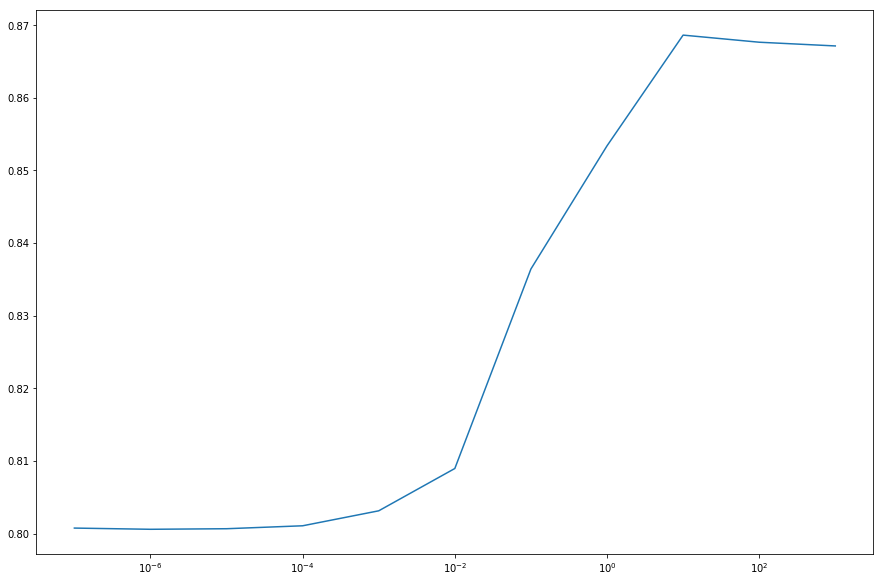

In [19]:
%%time
logit_params = np.logspace(-7, 3, 11)

logit = LogisticRegressionCV(Cs=logit_params, cv=tss, multi_class='ovr', scoring='roc_auc', random_state=SEED, n_jobs=-1)
logit.fit(X_train, y_train)
logit_cv_scores = logit.scores_.values()[0]
logit_mean_cv_scores = np.apply_along_axis(np.mean, 0, logit_cv_scores)
logit_best_C, logit_best_score = max(zip(logit_params, logit_mean_cv_scores), key=lambda x: x[1])
print('C: {}, score: {}'.format(logit_best_C, logit_best_score))
logit_valid_score = roc_auc_score(y_valid, logit.predict_proba(X_valid)[:, 1])
print('Score on valid: {}'.format(logit_valid_score))

plt.figure(figsize=(15, 10))
plt.plot(logit_params, logit_mean_cv_scores)
plt.xscale('log')

Теперь, когда видно, где параметр `C` достигает максимума, переберем его вновь в более подходящем промежутке:

C: 20.4335971786, score: 0.869656689157
Score on valid: 0.843323408658
Wall time: 3min 53s


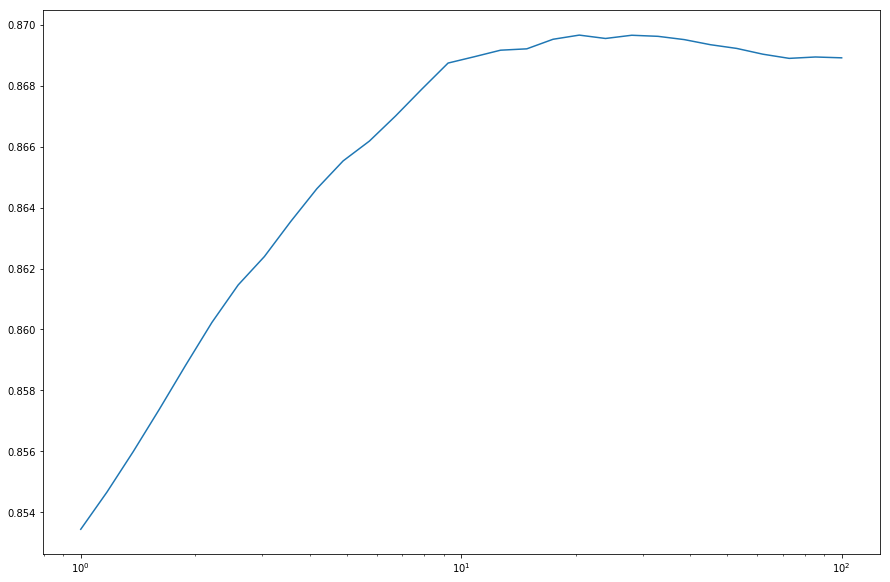

In [35]:
%%time
logit_params = np.logspace(0, 2, 30)

logit = LogisticRegressionCV(Cs=logit_params, cv=tss, multi_class='ovr', scoring='roc_auc', random_state=SEED, n_jobs=-1)
logit.fit(X_train, y_train)
logit_cv_scores = logit.scores_.values()[0]
logit_mean_cv_scores = np.apply_along_axis(np.mean, 0, logit_cv_scores)
logit_best_C, logit_best_score = max(zip(logit_params, logit_mean_cv_scores), key=lambda x: x[1])
print('C: {}, score: {}'.format(logit_best_C, logit_best_score))
logit_valid_score = roc_auc_score(y_valid, logit.predict_proba(X_valid)[:, 1])
print('Score on valid: {}'.format(logit_valid_score))

plt.figure(figsize=(15, 10))
plt.plot(logit_params, logit_mean_cv_scores)
plt.xscale('log')

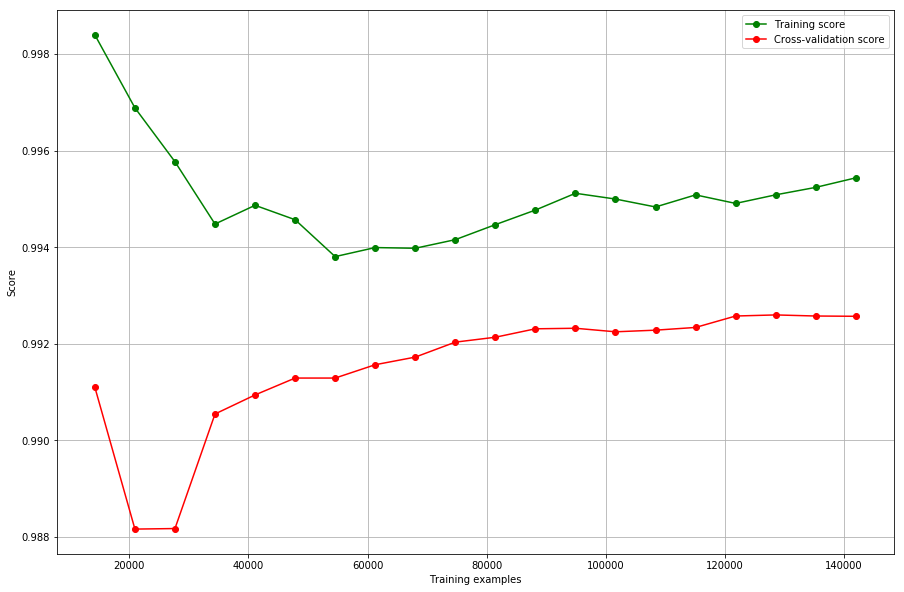

Wall time: 3min 58s


In [105]:
%%time
train_sizes_abs, train_scores, test_scores = learning_curve(LogisticRegression(C=logit_best_C, random_state=SEED, n_jobs=-1), 
                                                            X_train, y_train, 
                                                            train_sizes=np.linspace(0.1, 1.0, 20), cv=skf)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(15, 10))
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='g', label='Training score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color='r', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

### Оценка модели

Выведем значения основных метрик:

In [101]:
logit_valid_pred = logit.predict(X_valid)
print(classification_report(y_valid, logit_valid_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75368
           1       0.95      0.23      0.38       701

   micro avg       0.99      0.99      0.99     76069
   macro avg       0.97      0.62      0.69     76069
weighted avg       0.99      0.99      0.99     76069



Посмотрим, как выглядят сессии, на которых модель ошиблась:

In [102]:
error_sessions = pd.DataFrame(make_site_names(train_test_df_sites[:len(train_df)], site_dic, sparse=False), 
                              columns=train_test_df_sites.columns)
error_sessions['target'] = y
error_sessions = error_sessions[logit.predict(X_train_sparse) != y]

In [103]:
error_sessions[error_sessions['target'] == 1]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
3636,bing,bing,leboncoin,bing,twitter,leboncoin,leboncoin,leboncoin,leboncoin,leboncoin,1
3637,193.164.196.50,leboncoin,leboncoin,leboncoin,leboncoin,193.164.197.60,leboncoin,leboncoin,193.164.196.50,193.164.197.40,1
3638,193.164.197.30,leboncoin,leboncoin,193.164.196.60,193.164.197.40,193.164.196.30,193.164.196.40,193.164.197.60,193.164.197.50,leboncoin,1
3639,193.164.197.60,193.164.196.40,193.164.196.60,193.164.197.30,193.164.196.30,193.164.197.50,google,eulerian,leboncoin,leboncoin,1
3641,193.164.196.40,193.164.197.60,leboncoin,leboncoin,leboncoin,193.164.197.60,eulerian,193.164.196.40,leboncoin,leboncoin,1
3644,leboncoin,leboncoin,193.164.196.50,leboncoin,leboncoin,leboncoin,leboncoin,leboncoin,leboncoin,193.164.197.40,1
3647,193.164.196.50,leboncoin,193.164.197.60,leboncoin,193.164.197.40,leboncoin,193.164.197.60,193.164.196.50,leboncoin,leboncoin,1
3649,leboncoin,leboncoin,leboncoin,google,kelkoo,193.164.196.60,193.164.197.40,193.164.197.30,193.164.197.50,leboncoin,1
3658,193.164.196.50,leboncoin,leboncoin,193.164.196.40,193.164.196.30,leboncoin,leboncoin,193.164.197.60,193.164.197.50,193.164.197.40,1
3661,193.164.197.30,193.164.196.60,193.164.196.40,facebook,leboncoin,193.164.197.60,193.164.197.40,193.164.196.60,leboncoin,leboncoin,1


In [104]:
error_sessions[error_sessions['target'] == 0]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
6414,info-jeunes,info-jeunes,facebook,info-jeunes,info-jeunes,twitter,info-jeunes,facebook,google,twitter,0
10073,vk,facebook,facebook,facebook,vk,vk,vk,vk,vk,vk,0
10074,vk,vk,vk,vk,vk,vkadre,vk,vk,vkadre,vk,0
25682,google,youtube,ytimg,youtube,googlevideo,youtube,akamai,googlevideo,youtube,youtube,0
39299,youtube,google,googlevideo,ytimg,ytimg,youtube,youtube,googlevideo,youtube,googlevideo,0
47018,purepeople,msn,facebook,facebook,purepeople,facebook,facebook,twitter,purepeople,twitter,0
47157,googlevideo,youtube,googlevideo,youtube,ytimg,ytimg,googlevideo,ytimg,googlevideo,ytimg,0
50488,youtube,googlevideo,youtube,googlevideo,googlevideo,googlevideo,youtube,googlevideo,googlevideo,youtube,0
51232,youtube,ytimg,youtube,google,youtube,google,ytimg,ytimg,ytimg,ytimg,0
51248,googlevideo,youtube,googlevideo,youtube,ytimg,ytimg,youtube,youtube,ytimg,googlevideo,0


Можно видеть, что есть солидная доля сессий, состоящих целиком из таких сайтов, как google, youtube, facebook и т.д., принадлежащие как Alice, так и не Alice. Понятно, что вряд ли модель сможет отличить такие сессии по информации о сайтах. Такие сессии можно различить только по информации о времени, которая тоже вряд ли позволит различать все такие сессии. Иными словами, становится ясно, что мы не сможем достичь стопроцентного угадывания.

### Отправка результата на Kaggle

Обучим наилучшую найденную модель на всей обучающей выборке:

In [ ]:
#logit_best_C = 10

In [20]:
%%time
best_model = LogisticRegression(C=logit_best_C, random_state=SEED, n_jobs=-1).fit(X_train_sparse, y)
print('Train score = ', roc_auc_score(y, best_model.predict_proba(X_train_sparse)[:, 1]))

Train score =  0.9970000480357555
Wall time: 9.79 s


Построим предсказания на тестовой выборке (без целевого признака) и узнаем результат на публичном лидерборде в соревновании на Kaggle:

In [21]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [22]:
logit_test_pred_proba = best_model.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'LogReg_4feat.csv'))

Результат на публичном лидерборде - 0.94530.

### Выводы

Построенная модель может применяться в сфере информационной безопасности. С помощью модели можно определить, был ли совершен взлом аккаунта веб-сервиса, еще до того, как об этом заявит владелец аккаунта или злоумышленник совершит вредоносное действие. Таким же образом можно отслеживать нелегальную передачу аккаунта, например, продажу.

Существующие методы контроля доступа лишь затрудняют проникновение злоумышленника, но не решают проблему взлома полностью. Узким местом остается использование пароля, который может быть потерян, украден, перехвачен или подобран. Использование модели может помочь там, где эти методы бессильны - в ситуации, когда злоумышленник уже обладает паролем пользователя.

### Безуспешные эксперименты

Следующие попытки не принесли положительного результата (качество не улучшается):
* Использование кросс-валидации для временных рядов - `TimeSeriesSplit`
* Использование пар и троек последовательно идущих сайтов в качестве признаков
* Кодирование признаков с помощью tf-idf вместо обычных встречаемостей
* Использование признаков, касающихся времени сессии - длительность сессии; доля времени, проведенного на популярных сайтах
* Кодирование сайтов их суммарным временем посещения, нормированным на максимальную длину сессии (30 минут)

### Дальнейшие предложения

Для улучшения качества модели можно попробовать придумать и построить новые признаки, лучше отражающие информацию о сессии. 

Например:
* Попробовать многие другие признаки - длина сессии в секундах, количество уникальных сайтов, доля популярных сайтов (скажем, топ-30) в сессии, и т.д.